Using device: cpu
Loading dataset...
Noisy images shape: torch.Size([128, 3, 64, 64])
Clean images shape: torch.Size([128, 3, 64, 64])


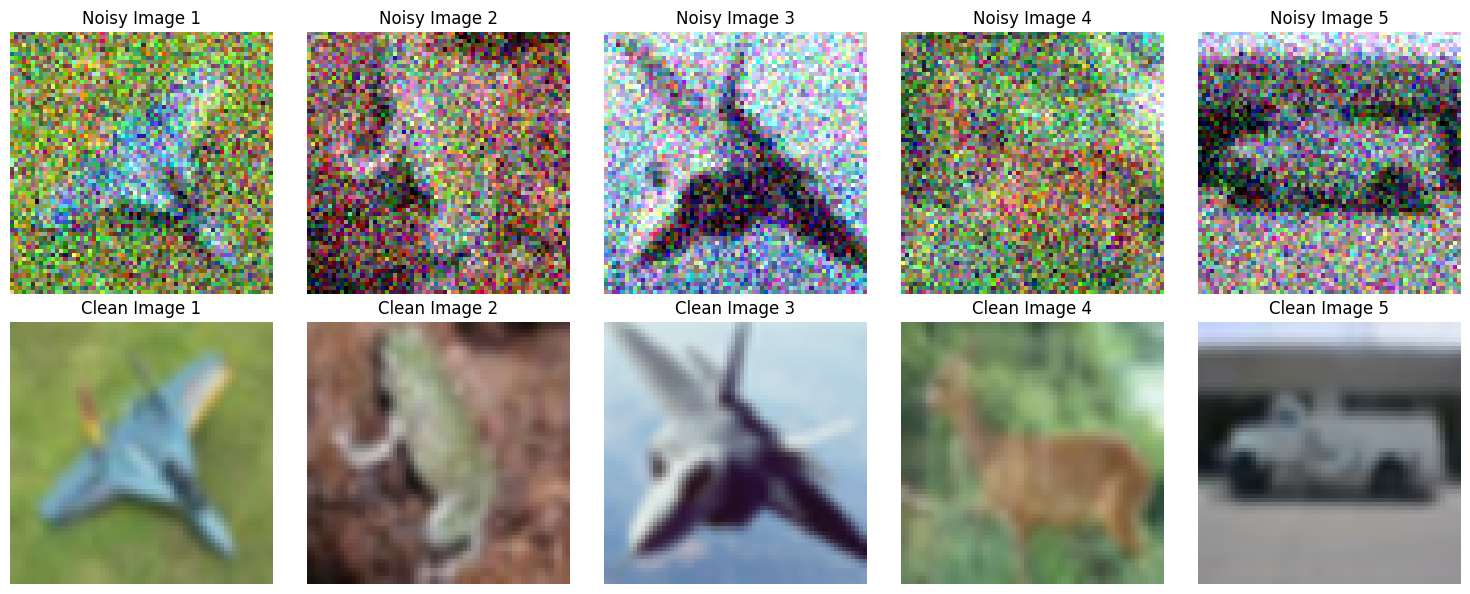

In [4]:
# Image Denoising with Deep Learning
# ================================
# This notebook implements an image denoising model using autoencoder architecture in PyTorch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class DenoisingDataset(Dataset):
    """Custom dataset for image denoising task"""

    def __init__(self, dataset, noise_level=0.2, transform=None):
        """
        Args:
            dataset: Base dataset with clean images
            noise_level: Standard deviation of Gaussian noise
            transform: Optional transform to be applied on clean images
        """
        self.dataset = dataset
        self.noise_level = noise_level
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get clean image
        clean_img, _ = self.dataset[idx]  # Ignore labels

        # Apply transform if provided
        if self.transform:
            clean_img = self.transform(clean_img)

        # Add Gaussian noise to create noisy image
        noise = torch.randn_like(clean_img) * self.noise_level
        noisy_img = clean_img + noise

        # Clip values to [0, 1] range
        noisy_img = torch.clamp(noisy_img, 0, 1)

        return noisy_img, clean_img

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

# Load CIFAR-10 dataset as clean images
# We'll use this standard dataset and create noisy versions
print("Loading dataset...")
clean_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split dataset into training and validation
train_size = int(0.8 * len(clean_dataset))
val_size = len(clean_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(clean_dataset, [train_size, val_size])

# Create denoising datasets
train_denoising_dataset = DenoisingDataset(train_dataset, noise_level=0.2)
val_denoising_dataset = DenoisingDataset(val_dataset, noise_level=0.2)

# Test dataset
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_denoising_dataset = DenoisingDataset(test_dataset, noise_level=0.2)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_denoising_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_denoising_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_denoising_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Visualize some examples
def show_images(noisy_images, clean_images, num_images=5):
    """Display noisy and clean image pairs"""
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        # Display noisy images in the first row
        axes[0, i].imshow(noisy_images[i].permute(1, 2, 0).cpu())
        axes[0, i].set_title(f"Noisy Image {i+1}")
        axes[0, i].axis('off')

        # Display clean images in the second row
        axes[1, i].imshow(clean_images[i].permute(1, 2, 0).cpu())
        axes[1, i].set_title(f"Clean Image {i+1}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch from the training dataset
sample_batch = next(iter(train_loader))
noisy_samples, clean_samples = sample_batch

print(f"Noisy images shape: {noisy_samples.shape}")
print(f"Clean images shape: {clean_samples.shape}")

# Visualize sample images
show_images(noisy_samples[:5], clean_samples[:5])

In [5]:
# PART 2: Model Architecture
# =========================

class DenoisingAutoencoder(nn.Module):
    """Autoencoder architecture for image denoising"""

    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # 128x128 -> 64x64

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # 64x64 -> 32x32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
        )

        # Decoder with skip connections
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 64x64 -> 128x128
            nn.Sigmoid()  # Output in range [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model
model = DenoisingAutoencoder().to(device)
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): 

Starting training...


Epoch 1/20: 100%|██████████| 313/313 [08:22<00:00,  1.61s/it]


Epoch 1/20, Training Loss: 0.0064, Validation Loss: 0.0032


Epoch 2/20: 100%|██████████| 313/313 [07:58<00:00,  1.53s/it]


Epoch 2/20, Training Loss: 0.0027, Validation Loss: 0.0034


Epoch 3/20: 100%|██████████| 313/313 [07:57<00:00,  1.53s/it]


Epoch 3/20, Training Loss: 0.0024, Validation Loss: 0.0023


Epoch 4/20: 100%|██████████| 313/313 [07:56<00:00,  1.52s/it]


Epoch 4/20, Training Loss: 0.0022, Validation Loss: 0.0021


Epoch 5/20: 100%|██████████| 313/313 [08:23<00:00,  1.61s/it]


Epoch 5/20, Training Loss: 0.0021, Validation Loss: 0.0021


Epoch 6/20: 100%|██████████| 313/313 [07:54<00:00,  1.52s/it]


Epoch 6/20, Training Loss: 0.0020, Validation Loss: 0.0020


Epoch 7/20: 100%|██████████| 313/313 [07:51<00:00,  1.51s/it]


Epoch 7/20, Training Loss: 0.0020, Validation Loss: 0.0019


Epoch 8/20: 100%|██████████| 313/313 [07:59<00:00,  1.53s/it]


Epoch 8/20, Training Loss: 0.0019, Validation Loss: 0.0019


Epoch 9/20: 100%|██████████| 313/313 [07:49<00:00,  1.50s/it]


Epoch 9/20, Training Loss: 0.0019, Validation Loss: 0.0019


Epoch 10/20: 100%|██████████| 313/313 [07:53<00:00,  1.51s/it]


Epoch 10/20, Training Loss: 0.0019, Validation Loss: 0.0017


Epoch 11/20: 100%|██████████| 313/313 [07:48<00:00,  1.50s/it]


Epoch 11/20, Training Loss: 0.0019, Validation Loss: 0.0019


Epoch 12/20: 100%|██████████| 313/313 [07:55<00:00,  1.52s/it]


Epoch 12/20, Training Loss: 0.0018, Validation Loss: 0.0017


Epoch 13/20: 100%|██████████| 313/313 [07:52<00:00,  1.51s/it]


Epoch 13/20, Training Loss: 0.0018, Validation Loss: 0.0017


Epoch 14/20: 100%|██████████| 313/313 [07:43<00:00,  1.48s/it]


Epoch 14/20, Training Loss: 0.0018, Validation Loss: 0.0017


Epoch 15/20: 100%|██████████| 313/313 [07:41<00:00,  1.47s/it]


Epoch 15/20, Training Loss: 0.0017, Validation Loss: 0.0018


Epoch 16/20: 100%|██████████| 313/313 [07:42<00:00,  1.48s/it]


Epoch 16/20, Training Loss: 0.0017, Validation Loss: 0.0017


Epoch 17/20: 100%|██████████| 313/313 [07:40<00:00,  1.47s/it]


Epoch 17/20, Training Loss: 0.0017, Validation Loss: 0.0017


Epoch 18/20: 100%|██████████| 313/313 [07:38<00:00,  1.46s/it]


Epoch 18/20, Training Loss: 0.0017, Validation Loss: 0.0016


Epoch 19/20: 100%|██████████| 313/313 [07:37<00:00,  1.46s/it]


Epoch 19/20, Training Loss: 0.0017, Validation Loss: 0.0016


Epoch 20/20: 100%|██████████| 313/313 [07:36<00:00,  1.46s/it]


Epoch 20/20, Training Loss: 0.0017, Validation Loss: 0.0015


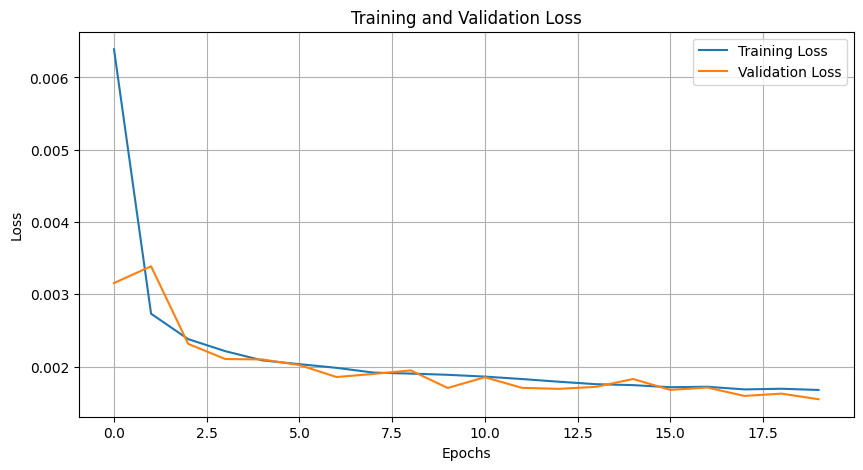

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    """Train the model and track loss"""

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0

        for noisy_imgs, clean_imgs in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * noisy_imgs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for noisy_imgs, clean_imgs in val_loader:
                noisy_imgs = noisy_imgs.to(device)
                clean_imgs = clean_imgs.to(device)

                outputs = model(noisy_imgs)
                val_loss = criterion(outputs, clean_imgs)

                running_val_loss += val_loss.item() * noisy_imgs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Training Loss: {epoch_train_loss:.4f}, '
              f'Validation Loss: {epoch_val_loss:.4f}')

        # Save some denoised images for visual inspection
        if (epoch + 1) % 5 == 0 or epoch == 0:
            save_denoised_images(model, val_loader, epoch + 1)

    return train_losses, val_losses

def save_denoised_images(model, data_loader, epoch):
    """Save some denoised images for visual comparison"""
    model.eval()

    # Get a batch of images
    noisy_imgs, clean_imgs = next(iter(data_loader))
    noisy_imgs = noisy_imgs.to(device)

    # Generate denoised images
    with torch.no_grad():
        denoised_imgs = model(noisy_imgs)

    # Create directory if it doesn't exist
    os.makedirs('denoised_images', exist_ok=True)

    # Save comparison grid (Noisy, Denoised, Clean)
    num_images = min(5, len(noisy_imgs))
    comparison = torch.cat((noisy_imgs[:num_images],
                           denoised_imgs[:num_images],
                           clean_imgs[:num_images].to(device)))

    save_image(comparison, f'denoised_images/comparison_epoch_{epoch}.png',
               nrow=num_images, normalize=False)

# Train the model
print("Starting training...")
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')
plt.show()


Evaluating model...


Evaluating: 100%|██████████| 79/79 [00:52<00:00,  1.49it/s]


Average PSNR on test set: 28.33 dB


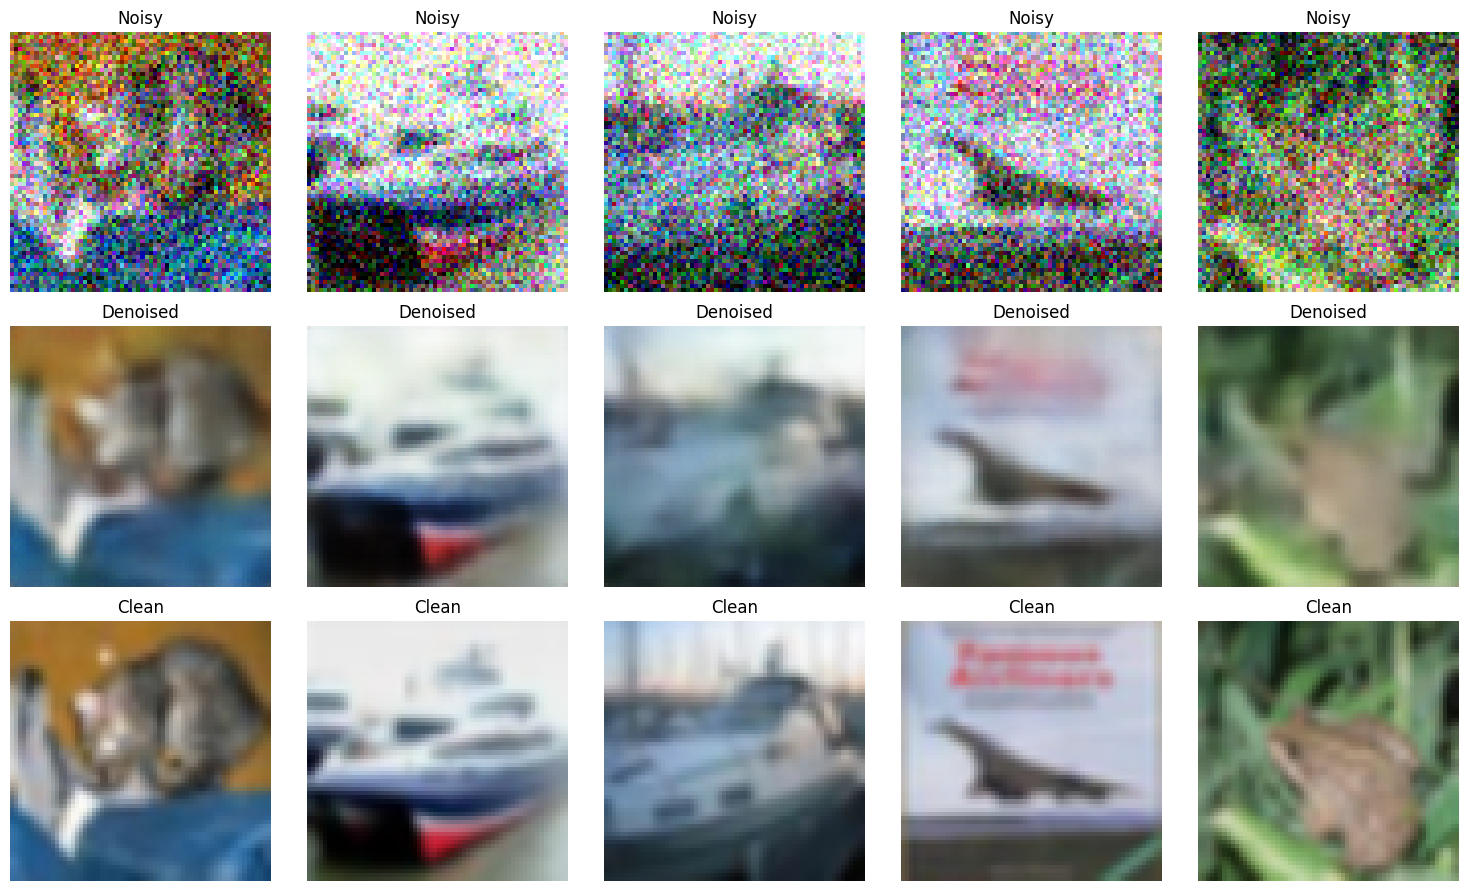

Model saved to 'denoising_autoencoder.pth'


In [7]:
def compute_psnr(img1, img2):
    """Compute Peak Signal-to-Noise Ratio between two images"""
    mse = torch.mean((img1 - img2) ** 2)
    return -10 * torch.log10(mse)

def evaluate_model(model, test_loader):
    """Evaluate model on test set and compute PSNR"""
    model.eval()
    total_psnr = 0.0
    count = 0

    with torch.no_grad():
        for noisy_imgs, clean_imgs in tqdm(test_loader, desc='Evaluating'):
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)

            # Generate denoised images
            denoised_imgs = model(noisy_imgs)

            # Compute PSNR for each image in the batch
            for i in range(len(clean_imgs)):
                psnr = compute_psnr(denoised_imgs[i], clean_imgs[i])
                total_psnr += psnr.item()
                count += 1

    avg_psnr = total_psnr / count
    print(f'Average PSNR on test set: {avg_psnr:.2f} dB')
    return avg_psnr

# Evaluate the model
print("Evaluating model...")
avg_psnr = evaluate_model(model, test_loader)

# Visualize some test results
def visualize_test_results(model, test_loader, num_images=5):
    """Visualize denoising results on test set"""
    model.eval()

    # Get a batch from test loader
    noisy_imgs, clean_imgs = next(iter(test_loader))
    noisy_imgs = noisy_imgs.to(device)

    # Generate denoised images
    with torch.no_grad():
        denoised_imgs = model(noisy_imgs)

    # Display results
    fig, axes = plt.subplots(3, num_images, figsize=(15, 9))

    for i in range(num_images):
        # Display noisy images in the first row
        axes[0, i].imshow(noisy_imgs[i].cpu().permute(1, 2, 0))
        axes[0, i].set_title(f"Noisy")
        axes[0, i].axis('off')

        # Display denoised images in the second row
        axes[1, i].imshow(denoised_imgs[i].cpu().permute(1, 2, 0))
        axes[1, i].set_title(f"Denoised")
        axes[1, i].axis('off')

        # Display clean images in the third row
        axes[2, i].imshow(clean_imgs[i].permute(1, 2, 0))
        axes[2, i].set_title(f"Clean")
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.savefig('test_results.png')
    plt.show()

# Visualize test results
visualize_test_results(model, test_loader)

# Save the model
torch.save(model.state_dict(), 'denoising_autoencoder.pth')
print("Model saved to 'denoising_autoencoder.pth'")


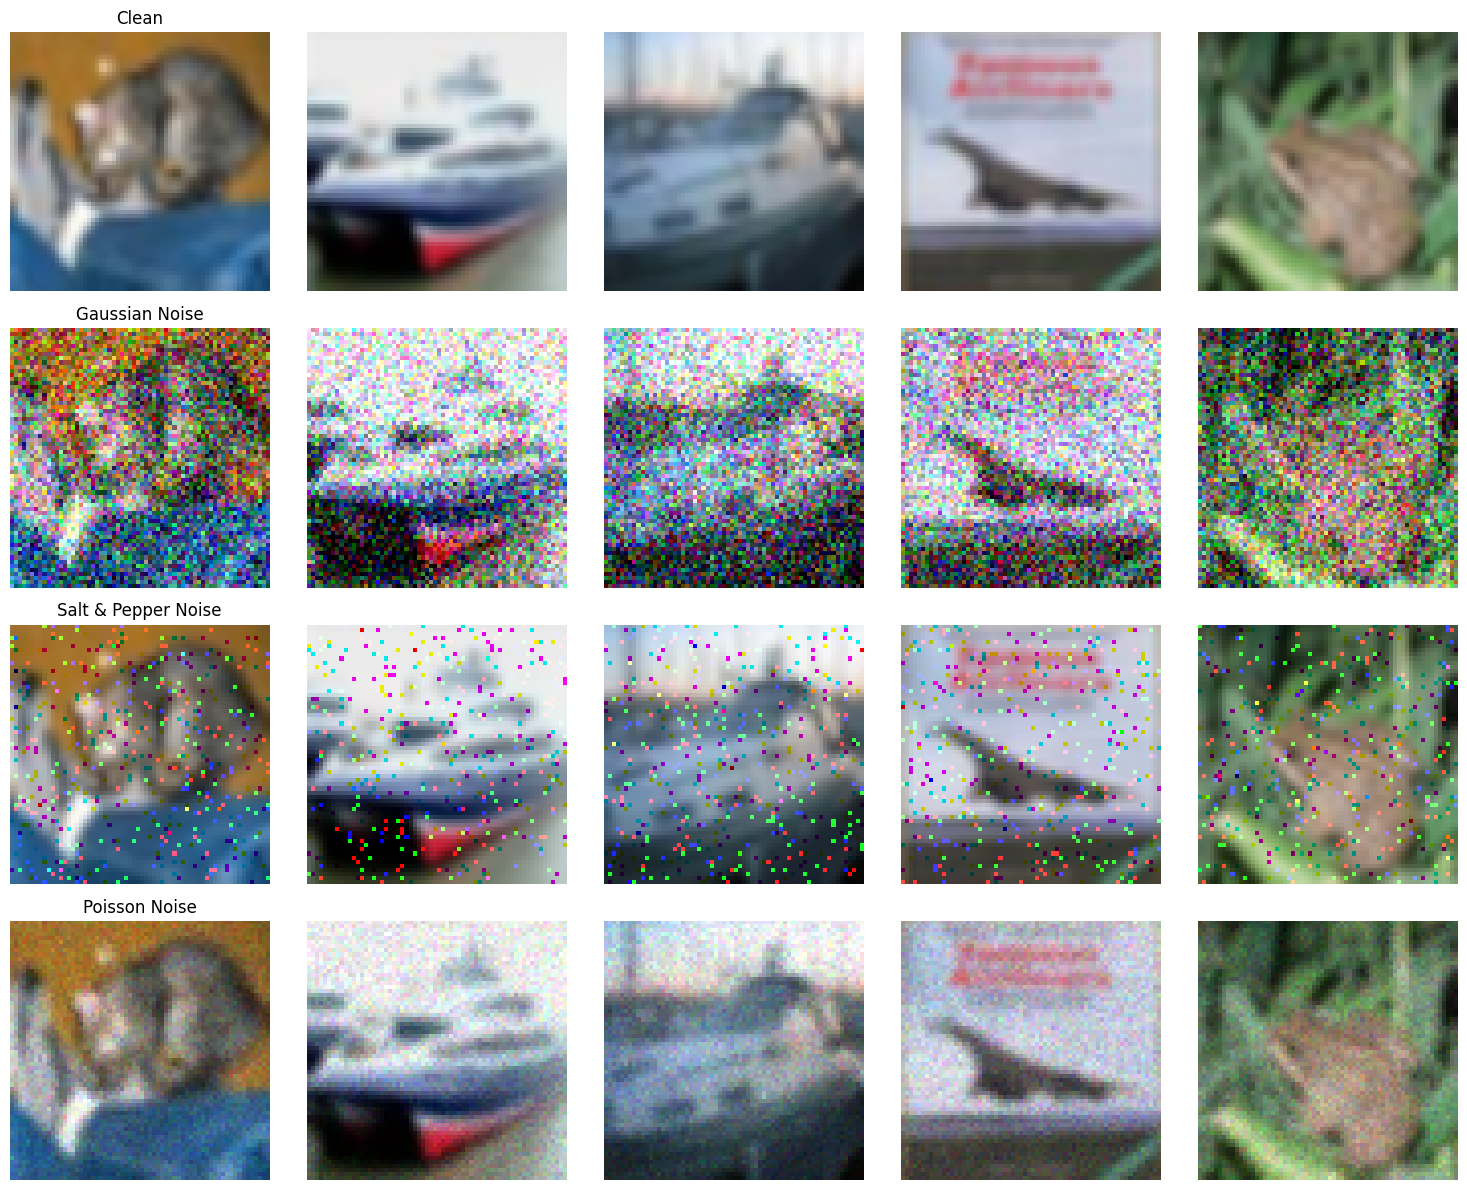

In [8]:

def create_salt_and_pepper_noise(images, salt_prob=0.02, pepper_prob=0.02):
    """Add salt and pepper noise to images"""
    noisy_images = images.clone()

    # Add salt noise (white pixels)
    salt_mask = torch.rand_like(images) < salt_prob
    noisy_images[salt_mask] = 1.0

    # Add pepper noise (black pixels)
    pepper_mask = torch.rand_like(images) < pepper_prob
    noisy_images[pepper_mask] = 0.0

    return noisy_images

def create_poisson_noise(images, lam=1.0):
    """Add Poisson noise to images"""
    # Scale images to avoid low-intensity issues
    scaled_images = images * 255.0

    # Generate Poisson noise
    noise = torch.poisson(scaled_images * lam) / (255.0 * lam) - scaled_images / 255.0

    # Add noise and clip to valid range
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0.0, 1.0)

    return noisy_images

# Get a batch of clean images for noise comparison
clean_batch = next(iter(test_loader))[1][:5]  # Get 5 clean images

# Create different types of noisy images
gaussian_noisy = clean_batch + 0.2 * torch.randn_like(clean_batch)
gaussian_noisy = torch.clamp(gaussian_noisy, 0, 1)

salt_pepper_noisy = create_salt_and_pepper_noise(clean_batch)
poisson_noisy = create_poisson_noise(clean_batch)

# Visualize different noise types
plt.figure(figsize=(15, 12))
noise_types = ['Clean', 'Gaussian Noise', 'Salt & Pepper Noise', 'Poisson Noise']
images = [clean_batch, gaussian_noisy, salt_pepper_noisy, poisson_noisy]

for i, (noise_type, img_batch) in enumerate(zip(noise_types, images)):
    for j in range(5):
        plt.subplot(4, 5, i*5 + j + 1)
        plt.imshow(img_batch[j].permute(1, 2, 0))
        if j == 0:
            plt.title(noise_type)
        plt.axis('off')

plt.tight_layout()
plt.savefig('noise_types_comparison.png')
plt.show()